In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten, Conv1D, AveragePooling1D, GlobalAveragePooling1D
import keras.optimizers as optimizers
from sklearn.preprocessing import MinMaxScaler

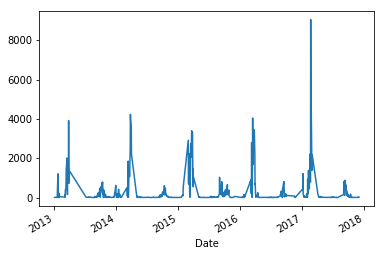

In [217]:
pollen = pd.read_csv("pollen.csv").sort_values("Date")
pollen['Date'] = pd.to_datetime(pollen['Date'])
pollen = pollen.set_index('Date').sum(axis=1)
pollen.plot()
plt.show()

In [218]:
init_weather = pd.read_csv("weather.csv").set_index('Date')
init_weather["precipm"] = init_weather["precipm"].astype("float64", errors='ignore')
weather = init_weather[["maxhumidity", 
                        "minhumidity", 
                        "maxtempm", 
                        "mintempm", 
                        "meanwindspdm", 
                        "minpressurem",
                        "maxpressurem",
                        "precipm",
                        "gdegreedays",
                        "coolingdegreedays",
                        "since1sepcoolingdegreedays",
                        "since1jancoolingdegreedays",
                        "heatingdegreedays",
                        "heatingdegreedaysnormal",
                        "since1sepheatingdegreedays",
                        "since1julheatingdegreedays",
                       ]]

In [219]:
pollen = pd.concat([pollen, weather], axis=1)

In [220]:
pollen = pollen.rename_axis('Date').reset_index()
pollen['Year'] = pollen['Date'].apply(lambda d: d.year)
pollen['Day'] = pollen['Date'].apply(lambda d: d.timetuple().tm_yday)
pollen = pollen.drop('Date', axis=1)
pollen = pollen.apply(lambda a: pd.to_numeric(a, errors='coerce')).fillna(0.0)
pollen.head()

,0,maxhumidity,minhumidity,maxtempm,mintempm,meanwindspdm,minpressurem,maxpressurem,precipm,gdegreedays,coolingdegreedays,since1sepcoolingdegreedays,since1jancoolingdegreedays,heatingdegreedays,heatingdegreedaysnormal,since1sepheatingdegreedays,since1julheatingdegreedays,Year,Day
0,6.0,81,66,8,5,19,1021,1025,0.00,0,0,0.0,0.0,22,0.0,0.0,0.0,2013,2
1,2.0,75,33,12,4,19,1024,1028,0.00,0,0,0.0,0.0,19,0.0,0.0,0.0,2013,3
2,2.0,66,50,9,8,18,1027,1031,0.00,0,0,0.0,0.0,18,0.0,0.0,0.0,2013,4
3,12.0,100,72,17,10,18,1011,1018,6.86,6,0,0.0,0.0,9,0.0,0.0,0.0,2013,8
4,8.0,100,46,22,13,13,1011,1016,0.00,13,0,0.0,0.0,2,0.0,0.0,0.0,2013,11


In [221]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_pollen = scaler.fit_transform(pollen)
scaled_pollen = pd.DataFrame(scaled_pollen, columns=pollen.columns)
pollen = scaled_pollen

In [222]:
scaled_pollen.head()

,0,maxhumidity,minhumidity,maxtempm,mintempm,meanwindspdm,minpressurem,maxpressurem,precipm,gdegreedays,coolingdegreedays,since1sepcoolingdegreedays,since1jancoolingdegreedays,heatingdegreedays,heatingdegreedaysnormal,since1sepheatingdegreedays,since1julheatingdegreedays,Year,Day
0,-0.998674,0.344828,0.218391,-0.684211,-0.515152,0.1875,0.419355,0.1875,-1.00000,-1.000000,-1.0,-1.0,-1.0,0.294118,-1.0,-1.0,-1.0,-1.0,-1.000000
1,-0.999558,0.137931,-0.540230,-0.473684,-0.575758,0.1875,0.612903,0.3750,-1.00000,-1.000000,-1.0,-1.0,-1.0,0.117647,-1.0,-1.0,-1.0,-1.0,-0.994475
2,-0.999558,-0.172414,-0.149425,-0.631579,-0.333333,0.1250,0.806452,0.5625,-1.00000,-1.000000,-1.0,-1.0,-1.0,0.058824,-1.0,-1.0,-1.0,-1.0,-0.988950
3,-0.997348,1.000000,0.356322,-0.210526,-0.212121,0.1250,-0.225806,-0.2500,-0.92033,-0.714286,-1.0,-1.0,-1.0,-0.470588,-1.0,-1.0,-1.0,-1.0,-0.966851
4,-0.998232,1.000000,-0.241379,0.052632,-0.030303,-0.1875,-0.225806,-0.3750,-1.00000,-0.380952,-1.0,-1.0,-1.0,-0.882353,-1.0,-1.0,-1.0,-1.0,-0.950276


In [223]:
train_set = pollen[pollen['Year'] <= 0.75]
test_set = pollen[pollen['Year'] > 0.75]

def series_to_supervised(df, time_steps):
    return np.array(list(zip(*[df.shift(i).as_matrix().astype('float64') for i in range(0, time_steps)])))[time_steps:]

train = series_to_supervised(train_set, 2)
test = series_to_supervised(test_set, 2)
#train = train_set.as_matrix().astype('float64')
#test = test_set.as_matrix().astype('float64')
print(train.shape)
print(test.shape)

(544, 2, 19)
(132, 2, 19)


In [224]:
x_train = train[:-1]
y_train = train[1:, 0, 0][:, None]
x_test = test[:-1]
y_test = test[1:, 0, 0][:, None]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(543, 2, 19)
(543, 1)
(131, 2, 19)
(131, 1)


In [225]:
num_features = x_train.shape[2]
num_labels = y_train.shape[1]
time_steps = x_train.shape[1]
batch_size = 64
model = Sequential()
#model.add(LSTM(32, batch_input_shape=(batch_size, time_steps, num_features), return_sequences=True))
#model.add(LSTM(32, return_sequences=True))
#model.add(LSTM(32))
#model.add(Dropout(0.5))
#model.add(Dense(100, activation='elu'))
#model.add(Dropout(0.5))
model.add(Conv1D(32, time_steps, activation='elu', input_shape=(None, num_features)))
model.add(Conv1D(32, 1, activation='elu'))
model.add(AveragePooling1D(1))
model.add(Conv1D(64, 1, activation='elu'))
model.add(Conv1D(64, 1, activation='elu'))
model.add(AveragePooling1D(1))
model.add(Conv1D(128, 1, activation='elu'))
model.add(Conv1D(128, 1, activation='elu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(100, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(num_labels, activation='elu'))
model.compile(loss='mae', optimizer='adam', metrics=['acc'])

In [226]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size, epochs=500, shuffle=True,
                    validation_data=(x_test, y_test))

Train on 543 samples, validate on 131 samples
Epoch 1/500
543/543 [==============================] - 54s 100ms/step - loss: 0.2986 - acc: 0.0000e+00 - val_loss: 0.0815 - val_acc: 0.0000e+00
Epoch 2/500
543/543 [==============================] - 0s 191us/step - loss: 0.0688 - acc: 0.0018 - val_loss: 0.0836 - val_acc: 0.0000e+00
Epoch 3/500
543/543 [==============================] - 0s 66us/step - loss: 0.0702 - acc: 0.0018 - val_loss: 0.0836 - val_acc: 0.0000e+00
Epoch 4/500
543/543 [==============================] - 0s 58us/step - loss: 0.0700 - acc: 0.0018 - val_loss: 0.0836 - val_acc: 0.0000e+00
Epoch 5/500
543/543 [==============================] - 0s 71us/step - loss: 0.0699 - acc: 0.0018 - val_loss: 0.0836 - val_acc: 0.0000e+00
Epoch 6/500
543/543 [==============================] - 0s 66us/step - loss: 0.0700 - acc: 0.0018 - val_loss: 0.0836 - val_acc: 0.0000e+00
Epoch 7/500
543/543 [==============================] - 0s 60us/step - loss: 0.0699 - acc: 0.0018 - val_loss: 0.0836 - v

543/543 [==============================] - 0s 65us/step - loss: 0.0686 - acc: 0.0018 - val_loss: 0.0827 - val_acc: 0.0000e+00
Epoch 60/500
543/543 [==============================] - 0s 59us/step - loss: 0.0692 - acc: 0.0018 - val_loss: 0.0827 - val_acc: 0.0000e+00
Epoch 61/500
543/543 [==============================] - 0s 61us/step - loss: 0.0694 - acc: 0.0018 - val_loss: 0.0829 - val_acc: 0.0000e+00
Epoch 62/500
543/543 [==============================] - 0s 60us/step - loss: 0.0691 - acc: 0.0018 - val_loss: 0.0830 - val_acc: 0.0000e+00
Epoch 63/500
543/543 [==============================] - 0s 62us/step - loss: 0.0681 - acc: 0.0018 - val_loss: 0.0822 - val_acc: 0.0000e+00
Epoch 64/500
543/543 [==============================] - 0s 66us/step - loss: 0.0697 - acc: 0.0018 - val_loss: 0.0821 - val_acc: 0.0000e+00
Epoch 65/500
543/543 [==============================] - 0s 69us/step - loss: 0.0682 - acc: 0.0018 - val_loss: 0.0816 - val_acc: 0.0000e+00
Epoch 66/500
543/543 [==================

Epoch 118/500
543/543 [==============================] - 0s 70us/step - loss: 0.0699 - acc: 0.0018 - val_loss: 0.0836 - val_acc: 0.0000e+00
Epoch 119/500
543/543 [==============================] - 0s 56us/step - loss: 0.0699 - acc: 0.0018 - val_loss: 0.0836 - val_acc: 0.0000e+00
Epoch 120/500
543/543 [==============================] - 0s 54us/step - loss: 0.0698 - acc: 0.0018 - val_loss: 0.0836 - val_acc: 0.0000e+00
Epoch 121/500
543/543 [==============================] - 0s 68us/step - loss: 0.0698 - acc: 0.0018 - val_loss: 0.0835 - val_acc: 0.0000e+00
Epoch 122/500
543/543 [==============================] - 0s 60us/step - loss: 0.0696 - acc: 0.0018 - val_loss: 0.0835 - val_acc: 0.0000e+00
Epoch 123/500
543/543 [==============================] - 0s 56us/step - loss: 0.0696 - acc: 0.0018 - val_loss: 0.0834 - val_acc: 0.0000e+00
Epoch 124/500
543/543 [==============================] - 0s 62us/step - loss: 0.0691 - acc: 0.0018 - val_loss: 0.0831 - val_acc: 0.0000e+00
Epoch 125/500
543/54

543/543 [==============================] - 0s 55us/step - loss: 0.0678 - acc: 0.0018 - val_loss: 0.0805 - val_acc: 0.0000e+00
Epoch 177/500
543/543 [==============================] - 0s 61us/step - loss: 0.0677 - acc: 0.0018 - val_loss: 0.0797 - val_acc: 0.0000e+00
Epoch 178/500
543/543 [==============================] - 0s 58us/step - loss: 0.0689 - acc: 0.0018 - val_loss: 0.0791 - val_acc: 0.0000e+00
Epoch 179/500
543/543 [==============================] - 0s 58us/step - loss: 0.0677 - acc: 0.0018 - val_loss: 0.0765 - val_acc: 0.0000e+00
Epoch 180/500
543/543 [==============================] - 0s 57us/step - loss: 0.0667 - acc: 0.0018 - val_loss: 0.0798 - val_acc: 0.0000e+00
Epoch 181/500
543/543 [==============================] - 0s 58us/step - loss: 0.0665 - acc: 0.0018 - val_loss: 0.0951 - val_acc: 0.0000e+00
Epoch 182/500
543/543 [==============================] - 0s 61us/step - loss: 0.0670 - acc: 0.0018 - val_loss: 0.0864 - val_acc: 0.0000e+00
Epoch 183/500
543/543 [===========

543/543 [==============================] - 0s 69us/step - loss: 0.0523 - acc: 0.0018 - val_loss: 0.0596 - val_acc: 0.0000e+00
Epoch 235/500
543/543 [==============================] - 0s 67us/step - loss: 0.0554 - acc: 0.0018 - val_loss: 0.0611 - val_acc: 0.0000e+00
Epoch 236/500
543/543 [==============================] - 0s 63us/step - loss: 0.0543 - acc: 0.0018 - val_loss: 0.0603 - val_acc: 0.0000e+00
Epoch 237/500
543/543 [==============================] - 0s 62us/step - loss: 0.0545 - acc: 0.0018 - val_loss: 0.0620 - val_acc: 0.0000e+00
Epoch 238/500
543/543 [==============================] - 0s 54us/step - loss: 0.0541 - acc: 0.0018 - val_loss: 0.0611 - val_acc: 0.0000e+00
Epoch 239/500
543/543 [==============================] - 0s 57us/step - loss: 0.0541 - acc: 0.0018 - val_loss: 0.0657 - val_acc: 0.0000e+00
Epoch 240/500
543/543 [==============================] - 0s 54us/step - loss: 0.0534 - acc: 0.0018 - val_loss: 0.0732 - val_acc: 0.0000e+00
Epoch 241/500
543/543 [===========

543/543 [==============================] - 0s 66us/step - loss: 0.0463 - acc: 0.0018 - val_loss: 0.0599 - val_acc: 0.0000e+00
Epoch 293/500
543/543 [==============================] - 0s 63us/step - loss: 0.0442 - acc: 0.0018 - val_loss: 0.0599 - val_acc: 0.0000e+00
Epoch 294/500
543/543 [==============================] - 0s 57us/step - loss: 0.0472 - acc: 0.0018 - val_loss: 0.0607 - val_acc: 0.0000e+00
Epoch 295/500
543/543 [==============================] - 0s 60us/step - loss: 0.0498 - acc: 0.0018 - val_loss: 0.0644 - val_acc: 0.0000e+00
Epoch 296/500
543/543 [==============================] - 0s 68us/step - loss: 0.0457 - acc: 0.0018 - val_loss: 0.0595 - val_acc: 0.0000e+00
Epoch 297/500
543/543 [==============================] - 0s 55us/step - loss: 0.0447 - acc: 0.0018 - val_loss: 0.0638 - val_acc: 0.0000e+00
Epoch 298/500
543/543 [==============================] - 0s 67us/step - loss: 0.0492 - acc: 0.0018 - val_loss: 0.0618 - val_acc: 0.0000e+00
Epoch 299/500
543/543 [===========

543/543 [==============================] - 0s 66us/step - loss: 0.0416 - acc: 0.0018 - val_loss: 0.0679 - val_acc: 0.0000e+00
Epoch 351/500
543/543 [==============================] - 0s 69us/step - loss: 0.0441 - acc: 0.0018 - val_loss: 0.0610 - val_acc: 0.0000e+00
Epoch 352/500
543/543 [==============================] - 0s 59us/step - loss: 0.0480 - acc: 0.0018 - val_loss: 0.0608 - val_acc: 0.0000e+00
Epoch 353/500
543/543 [==============================] - 0s 68us/step - loss: 0.0422 - acc: 0.0018 - val_loss: 0.0671 - val_acc: 0.0000e+00
Epoch 354/500
543/543 [==============================] - 0s 61us/step - loss: 0.0434 - acc: 0.0018 - val_loss: 0.0634 - val_acc: 0.0000e+00
Epoch 355/500
543/543 [==============================] - 0s 63us/step - loss: 0.0436 - acc: 0.0018 - val_loss: 0.0656 - val_acc: 0.0000e+00
Epoch 356/500
543/543 [==============================] - 0s 57us/step - loss: 0.0447 - acc: 0.0018 - val_loss: 0.0623 - val_acc: 0.0000e+00
Epoch 357/500
543/543 [===========

543/543 [==============================] - 0s 62us/step - loss: 0.0386 - acc: 0.0018 - val_loss: 0.0656 - val_acc: 0.0000e+00
Epoch 409/500
543/543 [==============================] - 0s 64us/step - loss: 0.0421 - acc: 0.0018 - val_loss: 0.0620 - val_acc: 0.0000e+00
Epoch 410/500
543/543 [==============================] - 0s 56us/step - loss: 0.0423 - acc: 0.0018 - val_loss: 0.0631 - val_acc: 0.0000e+00
Epoch 411/500
543/543 [==============================] - 0s 58us/step - loss: 0.0399 - acc: 0.0018 - val_loss: 0.0646 - val_acc: 0.0000e+00
Epoch 412/500
543/543 [==============================] - 0s 65us/step - loss: 0.0392 - acc: 0.0018 - val_loss: 0.0630 - val_acc: 0.0000e+00
Epoch 413/500
543/543 [==============================] - 0s 59us/step - loss: 0.0403 - acc: 0.0018 - val_loss: 0.0668 - val_acc: 0.0000e+00
Epoch 414/500
543/543 [==============================] - 0s 61us/step - loss: 0.0419 - acc: 0.0018 - val_loss: 0.0678 - val_acc: 0.0000e+00
Epoch 415/500
543/543 [===========

543/543 [==============================] - 0s 62us/step - loss: 0.0419 - acc: 0.0018 - val_loss: 0.0642 - val_acc: 0.0000e+00
Epoch 467/500
543/543 [==============================] - 0s 61us/step - loss: 0.0379 - acc: 0.0018 - val_loss: 0.0644 - val_acc: 0.0000e+00
Epoch 468/500
543/543 [==============================] - 0s 56us/step - loss: 0.0396 - acc: 0.0018 - val_loss: 0.0648 - val_acc: 0.0000e+00
Epoch 469/500
543/543 [==============================] - 0s 63us/step - loss: 0.0407 - acc: 0.0018 - val_loss: 0.0657 - val_acc: 0.0000e+00
Epoch 470/500
543/543 [==============================] - 0s 56us/step - loss: 0.0383 - acc: 0.0018 - val_loss: 0.0672 - val_acc: 0.0000e+00
Epoch 471/500
543/543 [==============================] - 0s 70us/step - loss: 0.0398 - acc: 0.0018 - val_loss: 0.0626 - val_acc: 0.0000e+00
Epoch 472/500
543/543 [==============================] - 0s 65us/step - loss: 0.0396 - acc: 0.0018 - val_loss: 0.0627 - val_acc: 0.0000e+00
Epoch 473/500
543/543 [===========

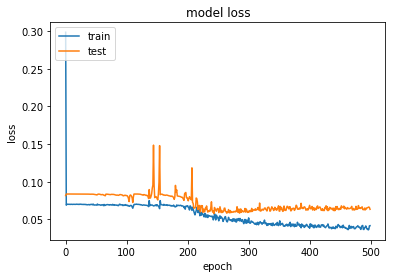

In [227]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [228]:
import random
index = int(random.random()*y_test.shape[0])
tomorrow = model.predict(x_test[index:index+5], batch_size=1)
print(tomorrow)
print(y_train[index:index+5])

[[-0.47002572]
 [-0.35067874]
 [-0.83955336]
 [-0.66333175]
 [-0.70941883]]
[[-0.13546961]
 [-0.84044199]
 [-0.82585635]
 [-0.70033149]
 [-0.99469613]]
